
== Training QSNet1988 (one-hot) ==
Epoch 01: Loss=0.9815  Test Acc=0.5635
Epoch 02: Loss=0.8874  Test Acc=0.5915
Epoch 03: Loss=0.8439  Test Acc=0.6073
Epoch 04: Loss=0.8211  Test Acc=0.6149
Epoch 05: Loss=0.8069  Test Acc=0.6195
Epoch 06: Loss=0.7984  Test Acc=0.6220
Epoch 07: Loss=0.7907  Test Acc=0.6180
Epoch 08: Loss=0.7831  Test Acc=0.6234
Epoch 09: Loss=0.7771  Test Acc=0.6217
Epoch 10: Loss=0.7720  Test Acc=0.6197
Epoch 11: Loss=0.7668  Test Acc=0.6050
Epoch 12: Loss=0.7617  Test Acc=0.6161
Epoch 13: Loss=0.7573  Test Acc=0.6149
Epoch 14: Loss=0.7504  Test Acc=0.6155
Epoch 15: Loss=0.7464  Test Acc=0.6161
Epoch 16: Loss=0.7391  Test Acc=0.6127
Epoch 17: Loss=0.7329  Test Acc=0.6081
Epoch 18: Loss=0.7256  Test Acc=0.6101
Epoch 19: Loss=0.7202  Test Acc=0.6178
Epoch 20: Loss=0.7120  Test Acc=0.6031
Epoch 21: Loss=0.7037  Test Acc=0.6079
Epoch 22: Loss=0.6971  Test Acc=0.6036
Epoch 23: Loss=0.6868  Test Acc=0.6033
Epoch 24: Loss=0.6794  Test Acc=0.5957
Epoch 25: Loss=0.6694  Test 

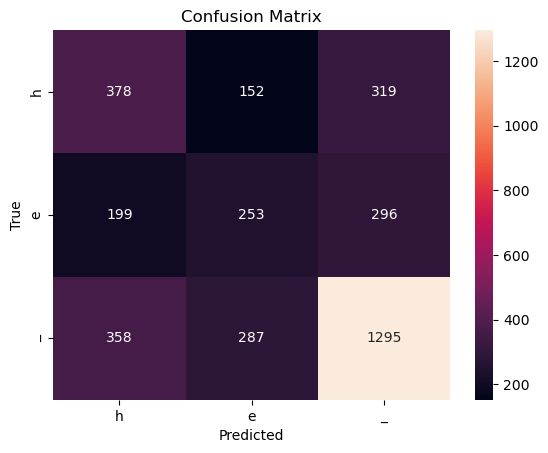


== Training QSNetPositional ==
Epoch 01: Loss=0.9936  Test Acc=0.5615
Epoch 02: Loss=0.8984  Test Acc=0.5835
Epoch 03: Loss=0.8531  Test Acc=0.6050
Epoch 04: Loss=0.8264  Test Acc=0.6070
Epoch 05: Loss=0.8104  Test Acc=0.6087
Epoch 06: Loss=0.7988  Test Acc=0.6152
Epoch 07: Loss=0.7912  Test Acc=0.6096
Epoch 08: Loss=0.7858  Test Acc=0.6192
Epoch 09: Loss=0.7778  Test Acc=0.6209
Epoch 10: Loss=0.7747  Test Acc=0.6161
Epoch 11: Loss=0.7684  Test Acc=0.6124
Epoch 12: Loss=0.7647  Test Acc=0.6163
Epoch 13: Loss=0.7562  Test Acc=0.6129
Epoch 14: Loss=0.7514  Test Acc=0.6158
Epoch 15: Loss=0.7454  Test Acc=0.6090
Epoch 16: Loss=0.7400  Test Acc=0.6073
Epoch 17: Loss=0.7343  Test Acc=0.6070
Epoch 18: Loss=0.7284  Test Acc=0.6113
Epoch 19: Loss=0.7199  Test Acc=0.6135
Epoch 20: Loss=0.7141  Test Acc=0.6011
Epoch 21: Loss=0.7063  Test Acc=0.6059
Epoch 22: Loss=0.6981  Test Acc=0.6025
Epoch 23: Loss=0.6915  Test Acc=0.5982
Epoch 24: Loss=0.6862  Test Acc=0.5881
Epoch 25: Loss=0.6762  Test Acc=

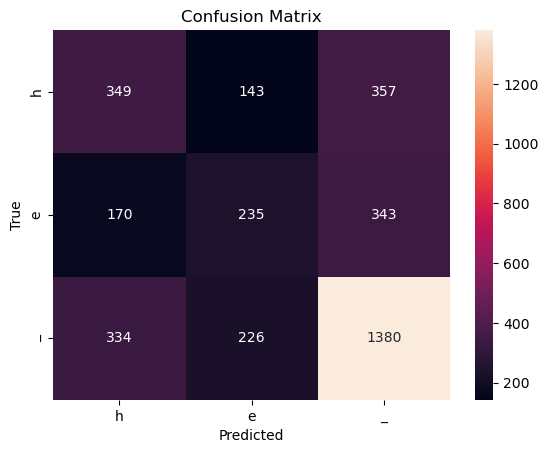


== SVM Baseline on one-hot ==

SVM Accuracy: 0.6056
              precision    recall  f1-score   support

       helix       0.47      0.58      0.52       849
       sheet       0.44      0.50      0.47       748
        coil       0.77      0.66      0.71      1940

    accuracy                           0.61      3537
   macro avg       0.56      0.58      0.57      3537
weighted avg       0.63      0.61      0.61      3537


CB513 file not found, skipping unseen evaluation.

Model Summary:
QSNet1988 Acc: 0.5445
Positional Acc: 0.5553
SVM Acc: 0.6056

All done!


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------
# 1. Data Parsing
# ---------------------

def parse_data(filename):
    """Parse Qian & Sejnowski formatted files"""
    sequences = []
    with open(filename, 'r') as f:
        current_seq = []
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            if line == '<end>':
                if current_seq:
                    sequences.append(current_seq)
                    current_seq = []
            else:
                parts = line.split()
                aa = parts[0]
                ss = parts[1] if len(parts) > 1 else '_'
                current_seq.append((aa, ss))
        # catch any trailing sequence
        if current_seq:
            sequences.append(current_seq)
    return sequences

# ---------------------
# 2. Encoding Utilities
# ---------------------
AMINO_ACIDS = list('ACDEFGHIKLMNPQRSTVWY') + ['X']  # X for unknown/padding
SS_CLASSES  = ['h', 'e', '_']  # helix, sheet, coil


def encode_window(window):
    """One-hot encode a 13-aa window"""
    vec = []
    for aa, _ in window:
        onehot = [0] * len(AMINO_ACIDS)
        idx = AMINO_ACIDS.index(aa) if aa in AMINO_ACIDS else AMINO_ACIDS.index('X')
        onehot[idx] = 1
        vec.extend(onehot)
    return vec


def create_dataset(sequences, window_size=13, positional=False):
    """
    Build X, y arrays.
    If positional=True, append normalized position feature.
    """
    half = window_size // 2
    X, y = [], []
    for seq in sequences:
        L = len(seq)
        padded = [('X', '_')] * half + seq + [('X', '_')] * half
        for i in range(L):
            window = padded[i:i+window_size]
            features = encode_window(window)
            if positional:
                # normalized position of center residue
                features.append(i / max(L-1, 1))
            label = SS_CLASSES.index(window[half][1])
            X.append(features)
            y.append(label)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int64)

# ---------------------
# 3. Model Definitions
# ---------------------

class QSNet1988(nn.Module):
    """Original Qian & Sejnowski (1988) replication"""
    def __init__(self, input_dim=13*21, hidden=40, output=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.fc2 = nn.Linear(hidden, output)
        self.tanh = nn.Tanh()
        self._init_weights()

    def _init_weights(self):
        for layer in (self.fc1, self.fc2):
            nn.init.uniform_(layer.weight, -0.5, 0.5)
            nn.init.uniform_(layer.bias,   -0.5, 0.5)

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        return self.fc2(x)

class QSNetPositional(QSNet1988):
    """Enhanced with a single-position feature"""
    def __init__(self):
        super().__init__(input_dim=13*21 + 1)

# ---------------------
# 4. Training & Evaluation
# ---------------------

def train_and_evaluate(model, train_loader, test_loader, epochs=50, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            out = model(X_batch)
            loss = criterion(out, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)

        # evaluate on test set
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                logits = model(X_batch)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(y_batch.numpy())
        acc = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch:02d}: Loss={avg_loss:.4f}  Test Acc={acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds,
          target_names=['helix','sheet','coil']))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=SS_CLASSES, yticklabels=SS_CLASSES)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return acc

# ---------------------
# 5. SVM Baseline
# ---------------------

def train_svm(X_train, y_train, X_test, y_test):
    scaler = StandardScaler().fit(X_train)
    X_tr_s = scaler.transform(X_train)
    X_te_s = scaler.transform(X_test)
    svm = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced')
    svm.fit(X_tr_s, y_train)
    y_pred = svm.predict(X_te_s)
    acc = accuracy_score(y_test, y_pred)
    print(f"\nSVM Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred,
          target_names=['helix','sheet','coil']))
    return acc

# ---------------------
# 6. Main Execution
# ---------------------
if __name__ == '__main__':
    # File paths (adjust as needed)
    train_file = 'protein-secondary-structure.train.txt'
    test_file  = 'protein-secondary-structure.test.txt'
    cb513_file = 'CB513.txt'  # optional unseen dataset

    # Load sequences
    train_seqs = parse_data(train_file)
    test_seqs  = parse_data(test_file)

    # Create one-hot datasets
    X_train, y_train = create_dataset(train_seqs)
    X_test,  y_test  = create_dataset(test_seqs)

    # DataLoaders
    BATCH = 32
    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train),
                                            torch.from_numpy(y_train)),
                              batch_size=BATCH, shuffle=True)
    test_loader  = DataLoader(TensorDataset(torch.from_numpy(X_test),
                                            torch.from_numpy(y_test)),
                              batch_size=BATCH)

    # 1) Original 1988 model
    print("\n== Training QSNet1988 (one-hot) ==")
    orig_model = QSNet1988()
    orig_acc = train_and_evaluate(orig_model, train_loader, test_loader)

    # 2) Positional improvement
    print("\n== Training QSNetPositional ==")
    X_train_p, y_train_p = create_dataset(train_seqs, positional=True)
    X_test_p,  y_test_p  = create_dataset(test_seqs,  positional=True)
    loader_tr_p = DataLoader(TensorDataset(torch.from_numpy(X_train_p),
                                            torch.from_numpy(y_train_p)),
                              batch_size=BATCH, shuffle=True)
    loader_te_p = DataLoader(TensorDataset(torch.from_numpy(X_test_p),
                                            torch.from_numpy(y_test_p)),
                              batch_size=BATCH)
    pos_model = QSNetPositional()
    pos_acc = train_and_evaluate(pos_model, loader_tr_p, loader_te_p)

    # 3) SVM baseline
    print("\n== SVM Baseline on one-hot ==")
    svm_acc = train_svm(X_train, y_train, X_test, y_test)

    # 4) Optional CB513 evaluation
    if os.path.exists(cb513_file):
        print("\n== Evaluating on CB513 (unseen) ==")
        cb_seqs = parse_data(cb513_file)
        X_cb, y_cb = create_dataset(cb_seqs)
        cb_loader = DataLoader(TensorDataset(torch.from_numpy(X_cb),
                                             torch.from_numpy(y_cb)),
                                 batch_size=BATCH)
        cb_acc = train_and_evaluate(orig_model, train_loader, cb_loader)
        print(f"CB513 Accuracy: {cb_acc:.4f}")
    else:
        print("\nCB513 file not found, skipping unseen evaluation.")

    # Summary
    print("\nModel Summary:")
    print(f"QSNet1988 Acc: {orig_acc:.4f}")
    print(f"Positional Acc: {pos_acc:.4f}")
    print(f"SVM Acc: {svm_acc:.4f}")
    if 'cb_acc' in locals():
        print(f"CB513 Acc: {cb_acc:.4f}")

    print("\nAll done!")
